<a href="https://colab.research.google.com/github/OdysseusPolymetis/colabs_for_nlp/blob/main/3_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyse de sentiments en français**

## 1. Les imports

In [ ]:
# Install PySpark and Spark NLP
! pip install -q pyspark==3.1.2 spark-nlp

In [ ]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [ ]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> popular


       | 
       | Downloading package cmudict to /root/nltk_data...
       |   Package cmudict is already up-to-date!
       | Downloading package gazetteers to /root/nltk_data...
       |   Package gazetteers is already up-to-date!
       | Downloading package genesis to /root/nltk_data...
       |   Package genesis is already up-to-date!
       | Downloading package gutenberg to /root/nltk_data...
       |   Package gutenberg is already up-to-date!
       | Downloading package inaugural to /root/nltk_data...
       |   Package inaugural is already up-to-date!
       | Downloading package movie_reviews to /root/nltk_data...
       |   Package movie_reviews is already up-to-date!
       | Downloading package names to /root/nltk_data...
       |   Package names is already up-to-date!
       | Downloading package shakespeare to /root/nltk_data...
       |   Package shakespeare is already up-to-date!
       | Downloading package stopwords to /root/nltk_data...
       |   Package stopword


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
spark = sparknlp.start()

In [ ]:
!gdown --id 1GEgd5cQoJkTm5PRWfixxOKHe3uOlxFqo

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GEgd5cQoJkTm5PRWfixxOKHe3uOlxFqo
To: /content/miserables.txt
100% 3.17M/3.17M [00:00<00:00, 209MB/s]


## 2. Les phrases à analyser



In [ ]:
filepath_of_text = "/content/miserables.txt"

In [ ]:
full_text = open(filepath_of_text, encoding="utf-8").read()

In [ ]:
jaccuse="J’accuse enfin le premier conseil de guerre d’avoir violé le droit, en condamnant un accusé sur une pièce restée secrète, et j’accuse le second conseil de guerre d’avoir couvert cette illégalité, par ordre, en commettant à son tour le crime juridique d’acquitter sciemment un coupable. En portant ces accusations, je n’ignore pas que je me mets sous le coup des articles 30 et 31 de la loi sur la presse du 29 juillet 1881, qui punit les délits de diffamation. Et c’est volontairement que je m’expose. Quant aux gens que j’accuse, je ne les connais pas, je ne les ai jamais vus, je n’ai contre eux ni rancune ni haine. Ils ne sont pour moi que des entités, des esprits de malfaisance sociale. Et l’acte que j’accomplis ici n’est qu’un moyen révolutionnaire pour hâter l’explosion de la vérité et de la justice. Je n’ai qu’une passion, celle de la lumière, au nom de l’humanité qui a tant souffert et qui a droit au bonheur. Ma protestation enflammée n’est que le cri de mon âme. Qu’on ose donc me traduire en cour d’assises et que l’enquête ait lieu au grand jour ! J’attends."

In [ ]:
from nltk.tokenize import sent_tokenize

In [ ]:
#sentences=sent_tokenize(full_text, language="french")
sentences=sent_tokenize(jaccuse, language="french")

In [ ]:
sentences

['J’accuse enfin le premier conseil de guerre d’avoir violé le droit, en condamnant un accusé sur une pièce restée secrète, et j’accuse le second conseil de guerre d’avoir couvert cette illégalité, par ordre, en commettant à son tour le crime juridique d’acquitter sciemment un coupable.',
 'En portant ces accusations, je n’ignore pas que je me mets sous le coup des articles 30 et 31 de la loi sur la presse du 29 juillet 1881, qui punit les délits de diffamation.',
 'Et c’est volontairement que je m’expose.',
 'Quant aux gens que j’accuse, je ne les connais pas, je ne les ai jamais vus, je n’ai contre eux ni rancune ni haine.',
 'Ils ne sont pour moi que des entités, des esprits de malfaisance sociale.',
 'Et l’acte que j’accomplis ici n’est qu’un moyen révolutionnaire pour hâter l’explosion de la vérité et de la justice.',
 'Je n’ai qu’une passion, celle de la lumière, au nom de l’humanité qui a tant souffert et qui a droit au bonheur.',
 'Ma protestation enflammée n’est que le cri de 

## 3. Construire la Pipeline

In [ ]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

embeddings = BertSentenceEmbeddings\
    .pretrained('labse', 'xx') \
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

sentimentClassifier = ClassifierDLModel.pretrained("classifierdl_bert_sentiment", "fr") \
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("class")   
  #.setInputCols(["document", "sentence_embeddings"]) 
     
nlpPipeline = Pipeline(stages=[
 document, 
 embeddings,
 sentimentClassifier
 ])

labse download started this may take some time.
Approximate size to download 1.7 GB
[OK!]
classifierdl_bert_sentiment download started this may take some time.
Approximate size to download 22.2 MB
[OK!]


## 5. Faire tourner sur le texte

In [ ]:
empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)
df = spark.createDataFrame(pd.DataFrame({"text":sentences}))
result = pipelineModel.transform(df)

## 6. Les résultats

In [ ]:
result.select(F.explode(F.arrays_zip('document.result', 'class.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("class")).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|document                                                                                                                                                                                                                                                                                     |class   |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|J’accuse enfin le premier conseil de guerre d’avoir violé le droit, en condamnant un accusé sur une pièce re

#**Les vecteurs de mots**

##**Définition**

Il faut s'imaginer le langage comme un ensemble de points (les mots) disposés dans un espace. La place de chaque mot est déterminée par celle de ses voisins. Ça, mathématiquement, ça fait qu'on peut percevoir les points comme des directions dans un espace donné. Et donc des vecteurs. Et donc on peut faire des maths avec.

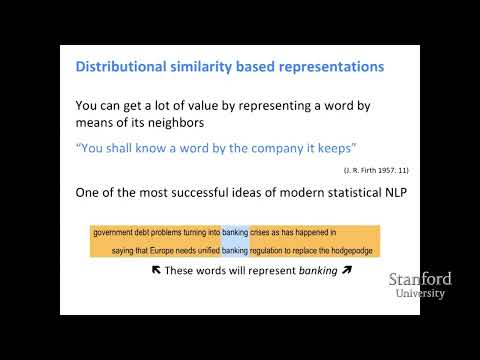

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("ORstNrlG_2g", width=512, height=288)

![](https://drive.google.com/uc?export=view&id=1FsTcOQ5LVgbDqkT5nm_gve5gZfQrZ8pV)

##**En pratique avec la Chartreuse de Parme**

In [2]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!gdown --id 1YWZPfc0PINJ0HpYp8HkqAuDZVsts8ikl
!curl -L -s -o /content/le_rouge_et_le_noir.txt 'https://drive.google.com/uc?id=1gTZgRAh0hEad0YgUKLFdGk42OU8JS5vK&confirm=t'

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YWZPfc0PINJ0HpYp8HkqAuDZVsts8ikl
To: /content/stopwords.txt
100% 4.65k/4.65k [00:00<00:00, 7.96MB/s]


In [4]:
rouge_et_noir = "/content/le_rouge_et_le_noir.txt"

In [24]:
stopwords=list()
stop = open("/content/stopwords.txt", 'r')
for word in stop.read().split(" "):
    stopwords.append(word)

In [27]:
import stanza
import string
stanza.download('fr')
nlp_stanza = stanza.Pipeline(lang='fr', processors='tokenize,mwt,pos,lemma')

INFO:stanza:Downloading default packages for language: fr (French) ...
INFO:stanza:File exists: /root/stanza_resources/fr/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [6]:
rouge_stanza=nlp_stanza(open(rouge_et_noir).read())

In [43]:
sents_rouge=list()
for sent in rouge_stanza.sentences:
  sentence=list()
  for token in sent.words:
    if token.lemma not in stopwords and token.lemma not in string.punctuation:
      sentence.append(token.lemma.lower())
  sents_rouge.append(sentence)

In [45]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=sents_rouge, size=300, window=50, min_count=2, workers=2)

In [47]:
sims = model.wv.most_similar('julien', topn=10)

In [48]:
sims

[('mathilde', 0.999988853931427),
 ('presque', 0.999988317489624),
 ('jour', 0.9999865293502808),
 ('œil', 0.999986469745636),
 ('bras', 0.99998539686203),
 ('main', 0.9999850988388062),
 ('homme', 0.9999847412109375),
 ('regarder', 0.9999843239784241),
 ('fort', 0.9999833703041077),
 ('appeler', 0.9999829530715942)]

In [50]:
odd = model.wv.doesnt_match(['sorel', 'mole', 'rênal'])
print("Le nom intrus est : {}".format(odd))

Le nom intrus est : rênal


/usr/local/lib/python3.8/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [52]:
model.wv.most_similar(positive=['bonaparte','julien'], negative=['empereur'])[0]

('arriver', 0.9995878338813782)